In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

from utils import *
from lda import LDAClassifier
from logistic import LogisticClassifier
from linear import LinearClassifier
from qda import QDAClassifier

import seaborn as sns
sns.set()

## Generative model (Linear Discriminant Analysis)

One observes i.i.d pairs $(x_j, y_j)_{j=1, \dots, n}$ where $x_j\in \mathbb{R}^p$ ($p=2$).

The statistical model of LDA is :
$$
y\sim Bernoulli(\pi),\\
x\lvert y=i \sim \mathcal{N}(\mu_i,\Sigma).
$$

We assume in addition that the system is non-degenerate i.e the covariance matrix $\Sigma$ is invertible.
The log-likelihood, written as a function of $\mu, C= \Sigma^{-1}, \pi$, is :

$$
\begin{aligned}
\log_{x,y}(\mu, C, \pi) &= \sum_{j=1}^n \log p(x_j \lvert y_j) + \log p(y_j)\\
&= \sum_{j=1}^n \mathbb{1}_{y_j=1} \log(\pi) + \mathbb{1}_{y_j=0} \log(1-\pi)\\
&\ \ \ \ \ + \mathbb{1}_{y_j=1} \log \bigg( \frac{1}{\sqrt{(2\pi)^p \det\Sigma}} \exp\big( -\frac{1}{2} (x_j-\mu_1)^\top C (x_j-\mu_1) \big) \bigg)\\
&\ \ \ \ \ + \mathbb{1}_{y_j=0} \log \bigg( \frac{1}{\sqrt{(2\pi)^p \det\Sigma}} \exp\big( -\frac{1}{2} (x_j-\mu_0)^\top C (x_j-\mu_0) \big) \bigg)\\
\end{aligned}
$$

i.e:
$$
\begin{aligned}
\log_{x,y}(\mu, C, \pi) &= \sum_{j=1}^n \mathbb{1}_{y_j=1} \big( \log(\pi) +\frac{1}{2} \log\det C - \frac{1}{2}(x_j-\mu_1)^\top C (x_j-\mu_1) \big)\\
&\ \ \ \ \ + \mathbb{1}_{y_j=0} \big( \log(\pi) +\frac{1}{2} \log\det C - \frac{1}{2}(x_j-\mu_0)^\top C (x_j-\mu_0) \big)\\
&\ \ \ \ \ + cst
\end{aligned}
$$

where $cst$ refers to constant terms with respect to $\mu, C, \pi$. Note that the sign before $\log\det C$ is obtained using $\log\det \Sigma^{-1} = -\log\det \Sigma$.

To maximize the log-likelihood $l$, let's compute its derivatives with respect to each parameter:

$$
\partial_{\pi} l_{x,y}(\mu, C, \pi) = \sum_{j=1}^n \mathbb{1}_{y_j=1}\frac{1}{\pi} - \mathbb{1}_{y_j=0}\frac{1}{1-\pi}
$$

which gives :
$$
\hat{\pi} = \frac{1}{n} \sum_{j=1}^n \mathbb{1}_{y_j=1}.
$$

For $\mu$:

$$
\nabla_{\mu_1} l_{x,y}(\mu, C, \pi) = \frac{1}{2}\sum_{j=1}^n \mathbb{1}_{y_j=1} \nabla_{\mu_1} \big( (x_j-\mu_1)^\top C (x_j-\mu_1) \big).
$$

The terms in the gradient with respect to $\mu_1$ is a quadratic form in $\mu_1-x_j$ associated to matrix $C$, hence:

$$
\nabla_{\mu_1} l_{x,y}(\mu, C, \pi) = \frac{1}{2}\sum_{j=1}^n \mathbb{1}_{y_j=1}C (x_j-\mu_1).
$$

Setting this to zero and multiplying by $\Sigma$ gives :

$$
\hat{\mu}_1 = \frac{\sum_{j=1}^n \mathbb{1}_{y_j=1}x_j}{\sum_{j=1}^n \mathbb{1}_{y_j=1}}.
$$

By symmetry we also get :

$$
\hat{\mu}_0 = \frac{\sum_{j=1}^n \mathbb{1}_{y_j=0}x_j}{\sum_{j=1}^n \mathbb{1}_{y_j=0}}.
$$

Finally, we have :
$$
\begin{aligned}
\partial_C l_{x,y}(\mu, C, \pi) &= \frac{1}{2}\sum_{j=1}^n \partial_C \log\det C\\
&\ \ \ \ \ - \mathbb{1}_{y_j=1} \partial_C (x_j-\mu_1)^\top C (x_j-\mu_1)\\
&\ \ \ \ \ - \mathbb{1}_{y_j=0} \partial_C (x_j-\mu_0)^\top C (x_j-\mu_0).
\end{aligned}
$$

Now matrix calculus gives : $\partial_C \log\det C = (C^{-1})^\top = \Sigma$ since $\Sigma$ is symmetric, and the other derivatives are applied on linear forms with respect to $C$, therefore:

$$
\partial_C l_{x,y}(\mu, C, \pi) = \frac{n}{2} \Sigma -\frac{1}{2} \sum_{j=1}^n \mathbb{1}_{y_j=1} (x_j-\mu_1)(x_j-\mu_1)^\top + \mathbb{1}_{y_j=0} (x_j-\mu_0)(x_j-\mu_0)^\top.
$$

Setting this to zero yields:

$$
\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^n \mathbb{1}_{y_j=1} (x_j-\mu_1)(x_j-\mu_1)^\top + \mathbb{1}_{y_j=0} (x_j-\mu_0)(x_j-\mu_0)^\top.
$$

Let's compute the decision boundary.
By Bayes rule : 
$$
\begin{aligned}
p(y=1\lvert x) &= \frac{p(x\lvert y=1)p(y=1)}{p(x)}\\
&= \frac{\pi}{p(x)} \frac{1}{\sqrt{(2\pi)^p \det\Sigma}} \exp\big( -\frac{1}{2} (x-\mu_1)^\top \Sigma^{-1} (x-\mu_1) \big)
\end{aligned}
$$

where $p(x)$ acts as a constant with respect to $y$.

The decision boundary $p(y=1\lvert x) = \frac{1}{2}$ is equivalent to $p(y=1\lvert x) = p(y=0\lvert x)$, which after cancelling terms and taking the log gives :

$$
(x-\mu_1)^\top \Sigma^{-1} (x-\mu_1) = (x-\mu_0)^\top \Sigma^{-1} (x-\mu_0).
$$

After reorganizing, we find that the decision boundary is affine:

$$
\begin{aligned}
& w^\top x = \lambda, \\
& w = \Sigma^{-1}(\mu_1 - \mu_0), \\
& \lambda = \frac{1}{2}(\mu_1^\top \Sigma^{-1} \mu_1 - \mu_0^\top \Sigma^{-1} \mu_0).
\end{aligned}
$$


By comparison, logisitc regression decision function is, with $S(u)=\frac{1}{1+e^{-u}}$ :

$$
p_{logistic}(y=1\lvert x) = S(w^\top x + b).
$$

The decision boundary is when the argument of the sigmoid function is zero, which also gives an affine boundary:

$$
w^\top x + b = 0.
$$

## QDA model

In QDA, one relaxes the assumption that all clusters share the same covariance. This leads to the following statistical model:

$$
y\sim Bernoulli(\pi),\\
x\lvert y=i \sim \mathcal{N}(\mu_i,\Sigma_i).
$$

The calculation for QDA is exactly the same as in LDA for $\mu$ and $\pi$. Let $C_0=\Sigma_0^{-1}$ and $C_1=\Sigma_1^{-1}$.

We have (using the same notations as in LDA):

$$
\begin{aligned}
\partial_{C_0} l_{x,y}(\mu, C_0, C_1, \pi) &= \frac{1}{2} \sum_{j=0}^n \mathbb{1}_{y_j=0}\big(\Sigma_0 -  (x_j-\mu_0)(x_j-\mu_0)^\top\big), \\
\partial_{C_1} l_{x,y}(\mu, C_0, C_1, \pi) &= \frac{1}{2} \sum_{j=1}^n \mathbb{1}_{y_j=1}\big(\Sigma_1 - (x_j-\mu_1)(x_j-\mu_1)^\top\big).
\end{aligned}
$$

Setting these to zero yields:

$$
\begin{aligned}
\hat{\Sigma}_0 &= \frac{1}{\sum_{j=1}^n \mathbb{1}_{y_j=0}} \sum_{j=0}^n \mathbb{1}_{y_j=0} (x_j-\mu_0)(x_j-\mu_0)^\top,\\
\hat{\Sigma}_1 &= \frac{1}{\sum_{j=1}^n \mathbb{1}_{y_j=1}} \sum_{j=1}^n \mathbb{1}_{y_j=1} (x_j-\mu_1)(x_j-\mu_1)^\top.
\end{aligned}
$$

## Initialize classifiers

In [2]:
LDA_clf = LDAClassifier()
Logistic_clf = LogisticClassifier()
Linear_clf = LinearClassifier()
QDA_clf = QDAClassifier()

classifiers = [
    LDA_clf,
    Logistic_clf,
    Linear_clf,
    QDA_clf,
]

## Test on blobs

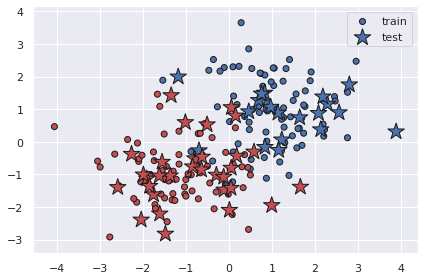

In [3]:
centers = [(-1, -1), (1, 1)]
X, y = make_blobs(n_samples=200, centers=centers, cluster_std=1.0)
dataset_split = train_test_split(X, y)
plot_dataset(dataset_split)


LDAClassifier(cov=array([[ 0.82412164, -0.02236834],
       [-0.02236834,  0.95265448]]),
              mu_0=array([-1.15891561, -0.92049563]),
              mu_1=array([0.96396181, 0.96181502]), pi=0.54) 

LogisticClassifier(b=0.41315782468580486, w=array([2.403855  , 1.61418663])) 

LinearClassifier(b=0.5279183013825136, w=array([0.19567404, 0.15153096])) 

QDAClassifier(cov_0=array([[ 0.95005728, -0.05077338],
       [-0.05077338,  0.73784991]]),
              cov_1=array([[0.71684313, 0.00182854],
       [0.00182854, 1.13563616]]),
              mu_0=array([-1.15891561, -0.92049563]),
              mu_1=array([0.96396181, 0.96181502]), pi=0.54) 



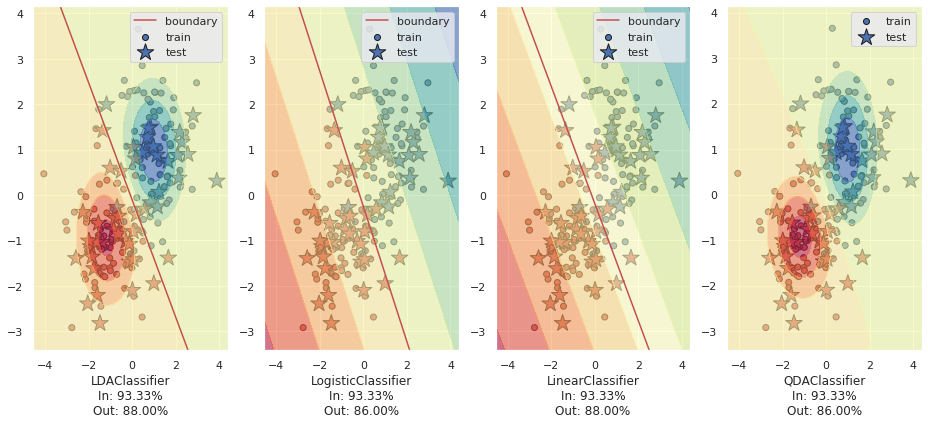

In [4]:
compare_classifiers_plot(dataset_split, classifiers, fname='', verbose=True)

### ROC curve

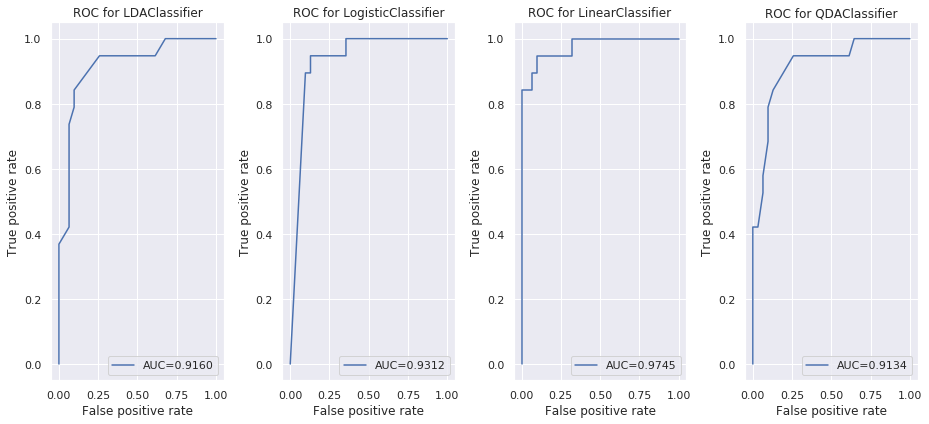

In [5]:
ROC(dataset_split, classifiers, fname='')